In [ ]:
# !pip install pymorphy3
# !pip install spacy
# !python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 36.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from pymorphy3 import MorphAnalyzer
from tensorflow.keras.models import load_model
import re

In [2]:
# Load the spaCy NLP model
try:
    nlp = spacy.load("ru_core_news_sm")
except:
    print("Russian spaCy model not found. Install it with: python -m spacy download ru_core_news_sm")
    exit()

In [4]:
# Initialize pymorphy3 analyzer
morph = MorphAnalyzer()

# Load the dataset
try:
    df = pd.read_csv('all_recepies_inter.csv', sep="\t", usecols=["name", "Инструкции","composition"])
    #df = df[:100]
    df = df.rename(columns={"Инструкции": "instructions"})
    df = df.rename(columns={"composition": "ingredients"})
except FileNotFoundError:
    print("Error: 'all_recepies_inter.csv' not found. Make sure the file is in the correct directory.")
    exit()

# Data Cleaning and Preprocessing
df = df.dropna(subset=['ingredients', 'instructions'])
df = df[df['ingredients'].apply(lambda x: isinstance(x, str))]
df = df[df['instructions'].apply(lambda x: isinstance(x, str))]
df['ingredients'] = df['ingredients'].apply(eval)

def _filter(token):
    """Filter tokens based on specific rules for Russian."""
    if len(token.text) < 2:
        return False
    if token.is_stop:
        return False
    if not token.text[0].isalpha():  # Exclude tokens starting with non-alphabetic characters
        return False
    if token.is_digit or token.like_num:
        return False
    return True

def get_labels(ingredients, tokenized_instructions):
    """Label generation using spaCy tokens and pymorphy2 lemmatization"""
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        # Extract and lemmatize ingredient names using pymorphy2
        ingredient_lemmas = set()
        for item in ing:
            if isinstance(item, dict):
                name = list(item.keys())[0]
                if name != 'unit':
                    # Process each token in the ingredient name
                    for token in nlp(name):
                        if _filter(token):
                            parsed = morph.parse(token.text)[0]
                            lemma = parsed.normal_form.lower()
                            ingredient_lemmas.add(lemma)

        # Create labels using pymorphy2 lemmas
        l_i = []
        for token in ti:
            if _filter(token):
                parsed = morph.parse(token.text)[0]
                lemma = parsed.normal_form.lower()
                l_i.append(float(lemma in ingredient_lemmas))
            else:
                l_i.append(0.0)
        labels.append(l_i)
    return labels

# Tokenize instructions using spaCy (Russian)
tokenized = [nlp(t) for t in df.instructions.values]

# Build Vocabulary
vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if token.text not in vocab.keys():
            vocab[token.text] = len(vocab)

# Create Labels
ingredients = df.ingredients
labels = get_labels(ingredients, tokenized)

# Sample recipe inspection
sample_idx = 15
sample_recipe = df.iloc[sample_idx]
sample_ingredients = sample_recipe['ingredients']
sample_instruction = sample_recipe['instructions']
sample_tokens = tokenized[sample_idx]
sample_labels = labels[sample_idx]

print("\n=== Пример рецепта ===")
print("Название:", sample_recipe['name'])
print("\nИнгредиенты:")
for ing in sample_ingredients:
    if isinstance(ing, dict):
        print("-", list(ing.keys())[0])
    else:
        print("-", ing)

print("\nИнструкция:")
print(sample_instruction)

print("\nТокены и метки:")
for token, label in zip(sample_tokens, sample_labels[:]):
    if _filter(token):
        parsed = morph.parse(token.text)[0]
        print(f"Токен: '{token.text}' (лемма pymorphy2: '{parsed.normal_form}'), Метка: {label}")
        if label == 1:
            for ing in sample_ingredients:
                if isinstance(ing, dict):
                    ing_name = list(ing.keys())[0]
                    for ing_token in nlp(ing_name):
                        if _filter(ing_token):
                            ing_parsed = morph.parse(ing_token.text)[0]
                            if ing_parsed.normal_form == parsed.normal_form:
                                print(f"   Совпадение с ингредиентом: '{ing_name}'")

# Prepare Sequences
MAX_LEN = 400

def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    """Convert tokens to sequences and pad them."""
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except IndexError:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


=== Пример рецепта ===
Название: Суп-пюре из чечевицы

Ингредиенты:
- Красная чечевица
- Морковь
- Лук
- Томатная паста
- Помидоры 
- Вода
- Соль
- Перец
- Растительное масло

Инструкция:
Подготовить указанные ингредиенты для приготовления супа-пюре из чечевицы. Готовить будем из красной чечевицы. Лук и морковь среднего размера. Вода горячая. Томатная паста и свежий помидор, я буду использовать томаты в собственном соку. Соль, перец по вкусу. Для подачи можно приготовить сметану и свежую зелень.
Овощи помыть, обсушить и очистить. Морковь можно порезать, можно натереть на тёрке (вид нарезки особо не имеет значения, поскольку все ингредиенты в дальнейшем будут перебиваться блендером. Но чем меньше будет шинковка, тем быстрее приготовятся овощи). Лук порезать.В кастрюле с толстым дном слегка обжарить подготовленные лук и морковь.
Красную чечевицу перебрать. Промыть под проточной водой до чистой воды.
Добавить промытую чечевицу к обжаренным овощам и тщательно перемешать всё.
Влить необход

In [ ]:
import pickle

# Save data
with open('data123.pkl', 'wb') as f:
    pickle.dump({
        'X_seq': X_seq,
        'y_seq': y_seq,
        'X_train': X_train,
        'X_val': X_val,
        'y_train': y_train,
        'y_val': y_val,
        'vocab': vocab
    }, f)



print(X_seq[1],X_seq.shape,"\n")
print(y_seq[1],y_seq.shape,"\n")


print("Распределение меток в y_train:", np.unique(y_train, return_counts=True))
print("Пример X_train[0]:", X_train[0][:10])
print("Пример y_train[0]:", y_train[0][:10])

[154   4  51 155 104  20 156  23 105  20 111  22 157  98 158 159 160 161
 162 163  77 164  51 165 156  23 104  27 166 110  27 167  64 168 169 125
  20 170 105  20 171  23 172   8 173  51  95 111 174  20 175 176 177  51
 178 126 111  77 179 102  51 180  73 181 177  51 155 175 182  51 183 182
  77 184 118 185 186  51 187  51 188  23 189 190  26 191 125  51  58 192
 170 193 194  20 195 196  23 197 198 199 125  51 200 111  77 164 201 202
  23 203 204  51 205   8 206  23 207 208  11 209 210 211   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_18            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_19            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_36                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.9801 - loss: 0.1803 - val_accuracy: 0.9921 - val_loss: 0.0695
Epoch 2/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.9922 - loss: 0.0675 - val_accuracy: 0.9924 - val_loss: 0.0655
Epoch 3/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.9928 - loss: 0.0616 - val_accuracy: 0.9921 - val_loss: 0.0697
Epoch 4/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 84s 62ms/step - accuracy: 0.9929 - loss: 0.0608 - val_accuracy: 0.9925 - val_loss: 0.0651
Epoch 5/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.9934 - loss: 0.0551 - val_accuracy: 0.9926 - val_loss: 0.0629
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9929 - loss: 0.0599
Validation Loss: 0.0629
Validation Accuracy: 0.9926


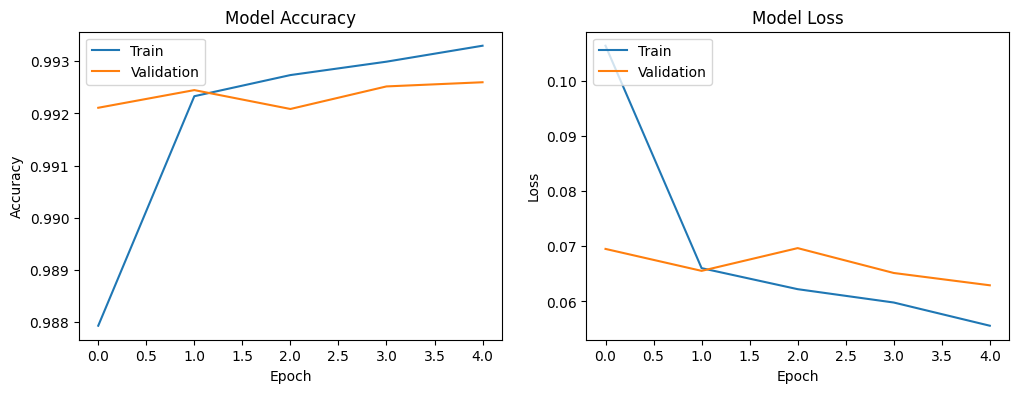

Model saved


In [ ]:
# Load data
with open('data123.pkl', 'rb') as f:
    data = pickle.load(f)
    X_seq = data['X_seq']
    y_seq = data['y_seq']
    X_train = data['X_train']
    X_val = data['X_val']
    y_train = data['y_train']
    y_val = data['y_val']
    vocab = data['vocab']

# Define the LSTM Model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(vocab), mask_zero=True, output_dim=50,input_length=X_train.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()

# Train the Model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


model.save('recognize_model.keras')
print("Model saved")

In [3]:
#тест(как должно быть)

loaded_model = load_model('recognize_model.keras')
# Load data
with open('data123.pkl', 'rb') as f:
    data = pickle.load(f)
    X_seq = data['X_seq']
    y_seq = data['y_seq']
    X_train = data['X_train']
    X_val = data['X_val']
    y_train = data['y_train']
    y_val = data['y_val']
    vocab = data['vocab']

# Рецепт пиццы
# recipe_text = """
# Приготовьте тесто для пиццы: смешайте 250 г муки, 150 мл воды, 7 г сухих дрожжей,
# 1 ст.л. оливкового масла и щепотку соли. Дайте тесту подняться 1 час.
# Для начинки нарежьте 200 г сыра моцарелла, 100 г ветчины, 1 помидор и 50 г шампиньонов.
# Разогрейте духовку до 220°C. Раскатайте тесто, смажьте 2 ст.л. томатного соуса,
# выложите начинку и посыпьте 1 ч.л. сушеного орегано. Выпекайте 12-15 минут.
# """

"""
Продукты
Для теста:
Мука пшеничная в/с - 250 г
Дрожжи сухие моментальные - 5 г
Сахар - 2 ч. ложки
Соль - 1/2 ч. ложки
Масло оливковое - 3 ст. ложки
Вода тёплая - 160 мл
*
Для начинки:
Колбаса варёно-копчёная - 150 г
Помидор - 1 шт. (100 г)
Сыр - 100 г
Томатный соус - 3 ст. ложки
"""

recipe_text = """
Не совсем правильная, но очень вкусная домашняя пицца на очень вкусном тесте.

Пошаговый фото рецепт
￼
Муку просеять в глубокую миску, добавить дрожжи, соль и сахар, перемешать.
Добавить теплую воду и оливковое масло, перемешать.
Переложить содержимое миски на припылённый мукой стол, замесить мягкое тесто. Скатать его в шар, накрыть полотенцем, оставить в тёплом месте на 1 час.
￼
После того как тесто поднимется, подмесить его и руками растянуть в лепешку толщиной 5-7 мм. Получится круг 33-35 см в диаметре.
Перенести тесто на противень, наколоть в нескольких местах вилкой, накрыть полотенцем и дать подняться (у меня это занимает столько времени, сколько я подготавливаю начинку).
￼
Тесто смазать томатным соусом.
￼
Разложить колбасу, нарезанную тонкими дольками.
￼
Затем разложить нарезанный тонкими дольками помидор.
￼
Посыпать сыром, натёртым на мелкой тёрке.
￼
Выпекать пиццу в духовке, нагретой до 190°C, 20 минут.
"""




def _filter(token):
    """Filter tokens based on specific rules for Russian."""
    if len(token.text) < 2:
        return False
    if token.is_stop:
        return False
    if not token.text[0].isalpha():  # Exclude tokens starting with non-alphabetic characters
        return False
    if token.is_digit or token.like_num:
        return False
    return True
# Prepare Sequences
MAX_LEN = 400
def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    """Convert tokens to sequences and pad them."""
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

def extract_ingredients(text, model, vocab, threshold=0.5):
    # Токенизация текста
    doc = nlp(text)

    # Подготовка последовательности
    test_tokenized = [doc]
    test_seq = prepare_sequences(test_tokenized, max_len=MAX_LEN, vocab=vocab)

    # Получение предсказаний
    prediction = model.predict(test_seq)
    predicted_probs = prediction[0][:len(doc)]

    # Постобработка для составных ингредиентов
    ingredients = []
    current_ingredient = []

    for token, prob in zip(doc, predicted_probs):
        if prob > threshold and _filter(token):
            # Начало нового ингредиента или продолжение предыдущего
            current_ingredient.append(token)
        elif current_ingredient:
            # Завершаем текущий ингредиент
            start = current_ingredient[0].idx
            end = current_ingredient[-1].idx + len(current_ingredient[-1].text)
            ingredients.append(text[start:end].strip())
            current_ingredient = []

    # Добавляем последний ингредиент, если остался
    if current_ingredient:
        start = current_ingredient[0].idx
        end = current_ingredient[-1].idx + len(current_ingredient[-1].text)
        ingredients.append(text[start:end].strip())

    return list(set(ingredients))  # Убираем дубликаты


# Извлечение и вывод ингредиентов
found_ingredients = extract_ingredients(recipe_text, loaded_model, vocab, threshold=0.4)



print("\n=== Результаты улучшенного извлечения ===")
print("\nНайденные ингредиенты:")
print("\n".join(f"- {ing}" for ing in found_ingredients))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step

=== Результаты улучшенного извлечения ===

Найденные ингредиенты:
- оливковое масло
- мукой
- помидор
- Муку
- колбасу
- сыром
- сахар
- воду
- соль
- дрожжи


In [3]:
#Метрики качества
loaded_model = load_model('recognize_model.keras')
# Load data
with open('data123.pkl', 'rb') as f:
    data = pickle.load(f)
    X_seq = data['X_seq']
    y_seq = data['y_seq']
    X_train = data['X_train']
    X_val = data['X_val']
    y_train = data['y_train']
    y_val = data['y_val']
    vocab = data['vocab']

from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

def evaluate_ner_model(model, X_test, y_test, vocab, threshold=0.6):
    # Get predictions
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)
    
    # Flatten the arrays for classification report
    y_test_flat = y_test.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_flat, y_pred_flat, average='binary', zero_division=0
    )
    accuracy = (y_pred_flat == y_test_flat).mean()
    
    # Classification report
    print("\n=== Token-level Classification Report ===")
    print(classification_report(
        y_test_flat, y_pred_flat, 
        target_names=['Non-Ingredient', 'Ingredient'],
        zero_division=0
    ))
    
    # Return metrics
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Evaluate on validation set
metrics = evaluate_ner_model(loaded_model, X_val, y_val, vocab)
print("\n=== Overall Metrics ===")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1-score:  {metrics['f1']:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step

=== Token-level Classification Report ===
                precision    recall  f1-score   support

Non-Ingredient       1.00      1.00      1.00   2158185
    Ingredient       0.90      0.86      0.88     72615

      accuracy                           0.99   2230800
     macro avg       0.95      0.93      0.94   2230800
  weighted avg       0.99      0.99      0.99   2230800


=== Overall Metrics ===
Precision: 0.9032
Recall:    0.8633
F1-score:  0.8828


In [2]:
import pickle

# Оригинальные данные
with open('data123.pkl', 'rb') as f:
    data = pickle.load(f)
    vocab = data['vocab']  # Берём только словарь

#Сохраняем только словарь
with open('minimal_data.pkl', 'wb') as f:
    pickle.dump({'vocab': vocab}, f)